In [ ]:
! pip install catboost
! pip install shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix,confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve,PrecisionRecallDisplay
from sklearn import metrics
from xgboost import *
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
import lightgbm
import catboost as ctb
from catboost import *
import shap
shap.initjs()
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


NewCreditCustomer [False  True]
Age [27 53 25 50 44 42 34 31 22 47 20 60 39 45 49 29 35 33 26 67 23 28 32 36
 24 61 46 54 68 69 43 30 56 37 58 64 40 55 38 41 52 51 70 48 21 62 59 65
 57 66 63 19 18 75 76 77  0  1  2 71 72 74]
Gender [1. 0. 2.]
Country ['EE' 'ES' 'FI' 'SK' 'NL']
Amount [ 3189.  2125.   531. ...  5751.  5235. 10300.]
Interest [0.3548 0.2097 0.2527 ... 0.4911 0.478  0.4784]
LoanDuration [ 60  48 119  12  36 115   6  18 118  24 120   9 113 117   3   1   2  13
   4   5  20  16  10   7   8  15  22  19  17  21  14  11  30  42  27  52
  38 114  54 116  72 108  66  78  90  96 102  84 112 110 111 109 107]
UseOfLoan [ -1   2   3   7   8   6   0   5   4   1 101 104 102 110 108 106 107]
Education [ 3.  4.  1.  5.  2. -1.  0.]
MaritalStatus [-1.  2.  4.  1.  3.  5.  0.]
EmploymentStatus [-1.  6.  5.  3.  2.  4.  0.]
EmploymentDurationCurrentEmployer ['UpTo5Years' 'MoreThan5Years' 'UpTo3Years' 'UpTo1Year' 'UpTo2Years'
 'Other' 'UpTo4Years' 'Retiree' 'TrialPeriod']
OccupationArea [-1.

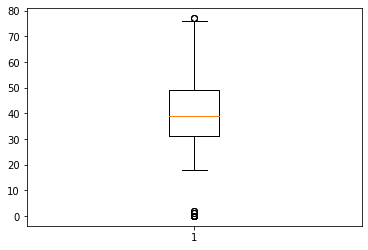

le boxplot de la variable Amount


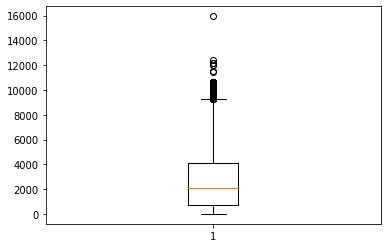

le boxplot de la variable Interest


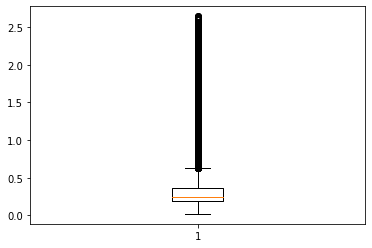

le boxplot de la variable LoanDuration


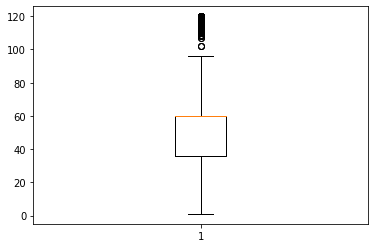

le boxplot de la variable IncomeTotal


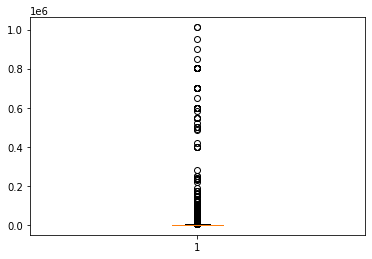

le boxplot de la variable AmountOfPreviousLoansBeforeLoan


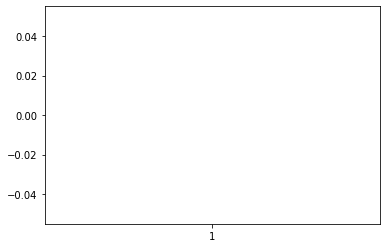

In [ ]:
# Importation des données
loan_data_frame = pd.read_csv("LoanData1.csv")

# Extraction des variables qu'on juge pertinentes pour notre étude
loan_data_frame = loan_data_frame[
    [
        "NewCreditCustomer",
        "Age",
        "Gender",
        "Country",
        "Amount",
        "Interest",
        "LoanDuration",
        "UseOfLoan",
        "Education",
        "MaritalStatus",
        "EmploymentStatus",
        "EmploymentDurationCurrentEmployer",
        "WorkExperience",
        "OccupationArea",
        "HomeOwnershipType",
        "IncomeTotal",
        "DefaultDate",
        "AmountOfPreviousLoansBeforeLoan",
    ]
]

# Création de notre variable cible "Default" depuis la variable "DefaultDate"
# Elle prend True si la valeur de DefaultDate est manquante et False sinon
loan_data_frame["Default"] = loan_data_frame["DefaultDate"].isnull()
loan_data_frame["Default"] = loan_data_frame["Default"].astype("str")

# Nous remplaçons True par 0 (le client est sain) et False par 1
loan_data_frame["Default"] = loan_data_frame["Default"].replace("True", 0)
loan_data_frame["Default"] = loan_data_frame["Default"].replace("False", 1)

# Nous supprimons ensuite la variable "DefaultDate"
loan_data_frame = loan_data_frame.drop("DefaultDate", axis=1)
loan_data_frame["Default"].value_counts()

# La variable "Interest" est exprimée en pourcentage
# Nous la divisons par 100
loan_data_frame["Interest"] = loan_data_frame["Interest"] / 100

"""
DataVisualisation
"""

class DataVisualisation:
    def __init__(self, data):
        self.data = data

    def description(self):
        return self.data.describe()

    def missing_data(self):
        return self.data.isnull().sum()

    def boxplot(self, column):
        plt.boxplot(column, vert=True)
        plt.show()

    def correlation(self, data):
        corr = data.corr()
        ax = sns.heatmap(
            corr,
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
        )
        ax.set_xticklabels(
            ax.get_xticklabels(), rotation=45, horizontalalignment="right"
        )
        plt.show()

    def histogram(self, column):
        sns.countplot(x=column, data=self.data, palette="hls")
        plt.xlabel(column.name)
        plt.ylabel("Fréquence")
        plt.show()

    def histogram_crosstab(self, column):
        table = pd.crosstab(column, loan_data_frame.Default)
        table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
        plt.ylabel("Défaut")
        plt.show()


"""
Preprocessing
"""
numerical_variables = loan_data_frame[
    [
        "Age",
        "Amount",
        "Interest",
        "LoanDuration",
        "IncomeTotal",
        "AmountOfPreviousLoansBeforeLoan"]
]

# Commençons par la descrition de nos variables quantitatives
numerical_dataviz = DataVisualisation(numerical_variables)
numerical_dataviz.description()

# Nous detectons ensuite les valeurs manquantes des différentes variables
loan_dataviz = DataVisualisation(loan_data_frame)
loan_dataviz.missing_data()

# Nous supprimons la variable "WorkExperience" vu que la majorité de ses valeurs sont manquantes
loan_data_frame = loan_data_frame.drop("WorkExperience", axis=1)

# Nous remplaçons les valeurs manquantes des variables qualitatives par leurs modes respectifs
categorical_columns = [
    "EmploymentDurationCurrentEmployer",
    "HomeOwnershipType",
    "OccupationArea",
    "EmploymentStatus",
    "MaritalStatus",
    "Education",
    "Gender",
    "UseOfLoan"]

# On passe à l'imputation
loan_data_frame[categorical_columns] = loan_data_frame[categorical_columns].fillna(
    loan_data_frame.mode().iloc[0]
)

# Pour la variable "AmountOfPreviousLoansBeforeLoan", si des valeurs sont manquantes,
# nous considérons que le client n'a pas de crédits antérieurs
# Nous remplaçons alors ces valeurs manquantes par 0

loan_data_frame["AmountOfPreviousLoansBeforeLoan"] = loan_data_frame[
    "AmountOfPreviousLoansBeforeLoan"
].fillna(0)

# Extraction des valeurs uniques des variables categorilles pour detecter les valeurs aberrantes
# !!! code à changer
for column in loan_data_frame:
    print(column, loan_data_frame[column].unique())


# Imputation des valeurs aberrantes (-1) des variables de la liste colonnes_aberrantes
# ci-dessous par 1
# En effet, nous considérons que c'est une erreur de saisie
outlier_columns = [
    "UseOfLoan",
    "MaritalStatus",
    "EmploymentStatus",
    "OccupationArea",
    "HomeOwnershipType"]
loan_data_frame[outlier_columns] = loan_data_frame[outlier_columns].replace({-1: 1})


# Suppression des ligne ayant des la valeur 0 pour les variables ci-dessous vu qu'elle ne figure pas parmi leur modalité
loan_data_frame = loan_data_frame.loc[
    (loan_data_frame["OccupationArea"] > 0)
    & (loan_data_frame["MaritalStatus"] > 0)
    & (loan_data_frame["EmploymentStatus"] > 0)
]

# Boxplots des variables quantitatives
for column in numerical_variables:
    print("le boxplot de la variable", column)
    loan_dataviz.boxplot(numerical_variables[column])

# Detection des valeurs aberrantes de la variable Age
loan_data_frame.loc[loan_data_frame["Age"] < 18, "Age"] = loan_data_frame[
    "Age"
].quantile(0.25)

# Détection des veleurs aberrantes au niveau de la variable
# "IncomeTotal" pour les clients qui ont un emploi
loan_data_frame.loc[
    (loan_data_frame["IncomeTotal"] <= 100) & (loan_data_frame["EmploymentStatus"] != 1)
]["IncomeTotal"].unique()

# Nous remarquons que nous avons la valeur 0
# qui figure au niveau de la variable "IncomeTotal" pour des gens employés
# Nous remplaçons alors cette valeur par le 1er quartile de la variable
loan_data_frame.loc[
    (loan_data_frame["IncomeTotal"] == 0) & (loan_data_frame["EmploymentStatus"] != 1),
    "IncomeTotal",
] = loan_data_frame["IncomeTotal"].quantile(0.25)


In [ ]:
#On convertit toutes les columns categorielles en en type category
categorical_columns = [
    "EmploymentDurationCurrentEmployer",
    "HomeOwnershipType",
    "OccupationArea",
    "EmploymentStatus",
    "MaritalStatus",
    "Education",
    "Gender",
    "NewCreditCustomer",
    "Country",
    "UseOfLoan"]

# Conversion des variables catégorielles en type categoriel
for categorical in categorical_columns:
  loan_data_frame[categorical]=loan_data_frame[categorical].astype("category")

loan_data_frame = pd.get_dummies(loan_data_frame, columns=categorical_columns, drop_first=False)


In [ ]:
#On étudie la corrélation entre les variables pour s'assurer de l'absence d
corr = loan_data_frame.corr()

corr.style.background_gradient(cmap='coolwarm')

In [ ]:
#Nous constatons que les classes la variable réponse n'est pas équilibrée. Il y a moins d'emprunteurs qui ont fait un défaut.
#On doit procéder à la correction du désequilibre
loan_data_frame["Default"].value_counts()

0    169471
1     86518
Name: Default, dtype: int64

In [ ]:

#print("Après le suréchantillonnage, le nombre de défauts '1': {}".format(sum(y_resampled == 1)))
#print("Après le suréchantillonnage, le nombre de non défauts  '0': {}".format(sum(y_resampled == 0)))
loan=loan_data_frame

loan["Default"].value_counts()

X = loan.loc[:,loan.columns != 'Default']
XX=X
y = loan["Default"]

random_seed = 666
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    random_state=42, stratify=y)

In [ ]:


sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train, y_train)


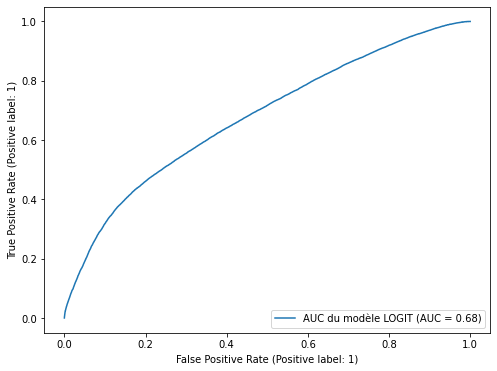

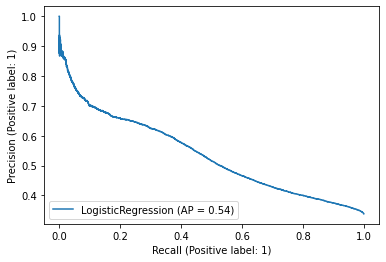

Log loss = 0.61364
AUC = 0.67731
Average Precision = 0.53529

Using 0.5 as threshold:
Accuracy = 0.68293
Precision = 0.53513
Recall = 0.47126
F1 score = 0.50117

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     50841
           1       0.54      0.47      0.50     25956

    accuracy                           0.68     76797
   macro avg       0.64      0.63      0.63     76797
weighted avg       0.67      0.68      0.68     76797

La matrice de Confusion


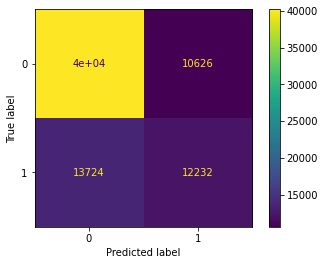

,variable,coefficient
0,intercept,0.034592
1,HomeOwnershipType_1.0,0.026885
2,OccupationArea_2.0,0.000075
3,UseOfLoan_7,0.440392
4,UseOfLoan_6,0.022819
...,...,...
83,Amount,0.000021
84,Interest,-0.000140
85,LoanDuration,0.000027
86,IncomeTotal,-0.000056


Accuracy: 0.7269815227157311
Accuracy = 0.72698
Precision = 0.59361
Recall = 0.60945
F1 score = 0.60143
[[40011 10830]
 [10137 15819]]
Accuracy :  0.7269815227157311
Precision =     0.594
Sensitivity :  0.786982946834248
Specificity :  0.609454461396209
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     50841
           1       0.70      0.62      0.65     25956

    accuracy                           0.78     76797
   macro avg       0.76      0.74      0.75     76797
weighted avg       0.78      0.78      0.78     76797

[[43899  6942]
 [ 9960 15996]]
Accuracy :  0.7799132778624165
Precision =     0.697
Sensitivity :  0.8634566589956925
Specificity :  0.6162736939435969


In [ ]:

#model = LogisticRegression(penalty='none') # LOGIT sans pénalisation .
model=LogisticRegression()
model.fit(X_train, y_train)
#AUC du modèle LOGIT
fig, ax = plt.subplots(figsize=(8, 6))
metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name='AUC du modèle LOGIT')

plt.show()

disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.show()

#Teste du modèle sur les données test
test_prob = model.predict_proba(X_test)[:, 1]
test_pred = model.predict(X_test)

#Evaluation des perfomrances du modèles
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

#Le résumé des résultats de prédiction pour notre problème de classification de défaut ou non dun emprunteur
print('La matrice de Confusion')

matrice_confusion = confusion_matrix(y_test, test_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion,
                            display_labels=model.classes_)
disp.plot()

plt.show()
#Identification des colonnes numériques et catégorielles
numcol=["Age","Amount","Interest","LoanDuration","IncomeTotal","AmountOfPreviousLoansBeforeLoan"]
catcol = list(set(loan.columns) - set(numcol) - {'Default'})

#Coefficients du modèle
coefficients = np.hstack((model.intercept_, model.coef_[0]))

dfcoeff=pd.DataFrame(data={'variable': ['intercept'] + catcol + numcol, 'coefficient': coefficients})

display(dfcoeff)

##import xlwings as xw
#wb=xw.Book("Userform_produit_digital_V1.xlsm")
#sheet = wb.sheets['Coefficients']
#sheet['A:Z'].value =dfcoeff

# # Prévision par ADABOOST

model_ADA= AdaBoostClassifier(n_estimators=20) # n_estimators={20,50,100,1000,!!5000 danger}
model_ADA.fit(X_train, y_train)

y_predADA = model_ADA.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_predADA))

print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_predADA)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_predADA)))
print('Recall = {:.5f}'.format(recall_score(y_test, y_predADA)))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_predADA)))
print(metrics.confusion_matrix(y_test, y_predADA))
cm0=metrics.confusion_matrix(y_test, y_predADA)
total1=sum(sum(cm0))
#####from confusion matrix calculate accuracy
accuracy=(cm0[0,0]+cm0[1,1])/total1
print ('Accuracy : ', accuracy)
tp = cm0[1,1]
fn = cm0[1,0]
fp = cm0[0,1]
tn = cm0[0,0]
print('Precision =     {:.3f}'.format(tp/(tp+fp)))

sensitivity = cm0[0,0]/(cm0[0,0]+cm0[0,1])
print('Sensitivity : ', sensitivity )

specificity = cm0[1,1]/(cm0[1,0]+cm0[1,1])
print('Specificity : ', specificity)

modelXGB = XGBClassifier(objective='binary:logistic',max_depth=11, booster='gbtree')

modelXGB.fit(X_train, y_train)

y_predXGB = modelXGB.predict(X_test)
accuracyXGB = accuracy_score(y_test, y_predXGB)
accuracyXGB
print(metrics.classification_report(y_test, y_predXGB))
print(metrics.confusion_matrix(y_test, y_predXGB))
cm1=metrics.confusion_matrix(y_test, y_predXGB)
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)
tp = cm1[1,1]
fn = cm1[1,0]
fp = cm1[0,1]
tn = cm1[0,0]
print('Precision =     {:.3f}'.format(tp/(tp+fp)))

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)


In [ ]:
proba=model.predict_proba(X_test)
print(proba,test_pred)

[[0.18372558 0.81627442]
 [0.58645595 0.41354405]
 [0.07890077 0.92109923]
 ...
 [0.35061035 0.64938965]
 [0.6169023  0.3830977 ]
 [0.44444124 0.55555876]] [1 0 1 ... 1 0 1]


In [ ]:
X_test.head().to_csv("ismael.csv")

In [ ]:
def fiabilite_model( liste_tupple_model_name, X_train, y_train,X_test, y_test ):
    ''' Cette fonction permet d'évaluer la fiabilité de tout modèle entrainé dans ce projet
        liste_tupple_model_name: est la liste de chaque tupple (modèle, nom du modèle)
        liste_tupple_model_name=[(modelLOGIT,"Régression logistique"),(modelXGBoost,"XGBOOST")]
        X_train, y_train, X_test, y_test : des classiques
    '''
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.cm.get_cmap("Dark2")
    names=[]
    #tupple_model=(model, name)
    #liste_modele=[]
    #liste_modele.append(model_name)
    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    affichage_calibrage = {}
    for rang, (model, name) in enumerate(liste_tupple_model_name):
        model.fit(X_train, y_train)
        display = CalibrationDisplay.from_estimator(
            model,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(rang),
        )
        affichage_calibrage[name] = display
        names.append(name + " , ")

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Diagramme de fiabilié du modèle")

    # Ajout de l'histogramme
    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
    for rang, (_, name) in enumerate(liste_tupple_model_name):
        row, col = grid_positions[rang]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            affichage_calibrage[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(rang),
        )
        ax.set(title=name, xlabel="Probabilité moyenne prédite", ylabel="Nombre de positifs")

    plt.tight_layout()
    plt.show()




In [ ]:
modelLightgbm = lightgbm.LGBMClassifier(objective='binary', max_depth = 11, verbose_eval = 10)
modelLightgbm.fit(X_train, y_train)


LGBMClassifier(max_depth=11, objective='binary', verbose_eval=10)

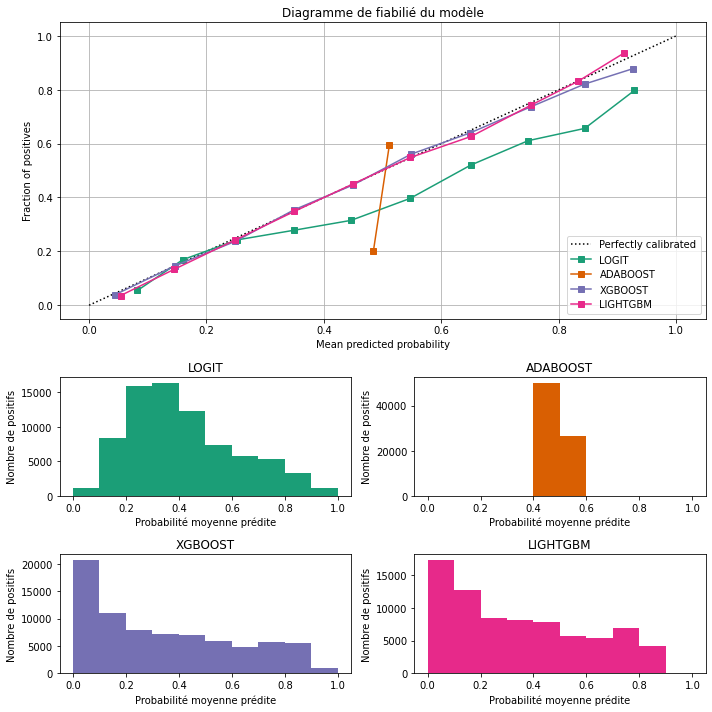

In [ ]:
fiabilite_model([(model, "LOGIT"), (model_ADA,"ADABOOST"), (modelXGB,"XGBOOST"), (modelLightgbm, "LIGHTGBM")],X_train,y_train,X_test,y_test)

In [ ]:
y_predLGBM=modelLightgbm.predict(X_test)
print(metrics.classification_report(y_test, y_predLGBM))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83     50841
           1       0.68      0.59      0.63     25956

    accuracy                           0.77     76797
   macro avg       0.74      0.72      0.73     76797
weighted avg       0.76      0.77      0.76     76797



In [ ]:
cmlgbm=metrics.confusion_matrix(y_test, y_predLGBM)
totallgbm=sum(sum(cmlgbm))
#####from confusion matrix calculate accuracy
accuracy1=(cmlgbm[0,0]+cmlgbm[1,1])/totallgbm
print ('Accuracy : ', accuracy1)
tp = cmlgbm[1,1]
fn = cmlgbm[1,0]
fp = cmlgbm[0,1]
tn = cmlgbm[0,0]
print('Precision =     {:.3f}'.format(tp/(tp+fp)))

sensitivity1 = cmlgbm[0,0]/(cmlgbm[0,0]+cmlgbm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cmlgbm[1,1]/(cmlgbm[1,0]+cmlgbm[1,1])
print('Specificity : ', specificity1)


Accuracy :  0.7679206218992929
Precision =     0.682
Sensitivity :  0.860407938474853
Specificity :  0.5867622129758052


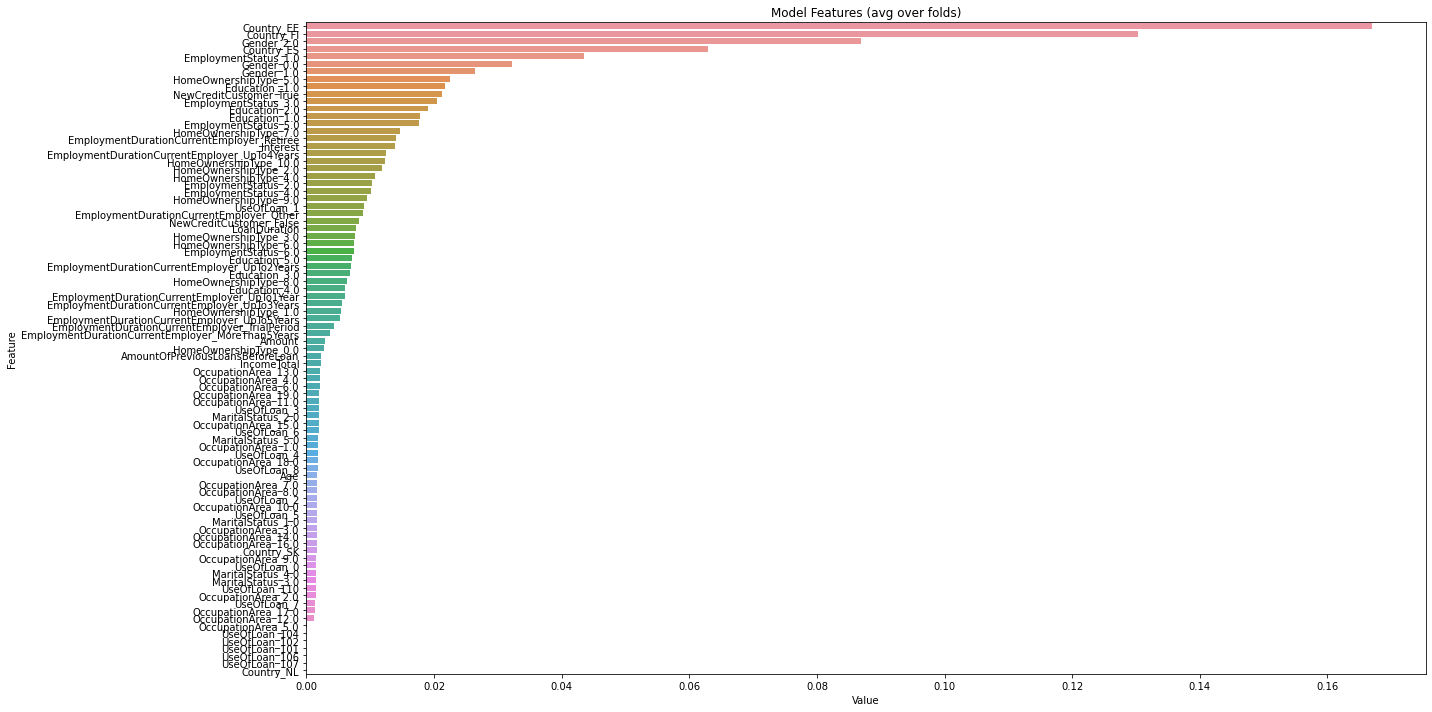

In [ ]:
# Pertinence des variables du modèles
feature_imp = pd.DataFrame(sorted(zip(modelXGB.feature_importances_,XX.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Model Features (avg over folds)')
plt.tight_layout()
plt.show()


In [ ]:
def shap_treeexplainer(model, X_train):
    '''
    Cette fonction fournit des informations sur les paramètres qui ont influencés chaque valeur prédite.
    Elle donne l'importance globale des variables en utilisant les valeurs de Shap
    la longueur des barres de chaque variable est équivaut à son influence sur la prédiction

    :param model: le modèle ensembliste entrainer
    :param X_train: les données sur lesquelles le modèle a été entrainé
    :return: l'influence de chaque
    '''
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train)



In [ ]:
#shap_treeexplainer(modelXGB, X_train)

# MAKING PIPELINE


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import plot_calibration_curve
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("data.csv")

# Create a column transformer that applies one-hot encoding to categorical features
categorical_features = ["feature1", "feature2"]
categorical_transformer = OneHotEncoder()
column_transformer = make_column_transformer(
    (categorical_transformer, categorical_features)
)

# Transform the data using the column transformer
X = column_transformer.fit_transform(data)
y = data["target"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and train an XGBoost regressor
reg = XGBRegressor(n_estimators=1000, learning_rate=0.1)
reg.fit(X_train, y_train)

# Plot calibration curve
plt.figure(figsize=(10, 10))
disp = plot_calibration_curve(reg, X_test, y_test, n_bins=10)
disp.ax_.set_title("Calibration Plot")
plt.show()


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, plot_roc_curve, calibration_curve
import matplotlib.pyplot as plt
from yellowbrick.classifier import CalibrationCurve

# Load data
data = pd.read_csv("data.csv")

# Create a column transformer that applies one-hot encoding to categorical features
categorical_features = ["feature1", "feature2"]
categorical_transformer = OneHotEncoder()
column_transformer = make_column_transformer(
    (categorical_transformer, categorical_features)
)

# Transform the data using the column transformer
X = column_transformer.fit_transform(data)
y = data["target"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and train a KNN classifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Print the classification report
print(classification_report(y_test, y_pred))

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
disp = CalibrationDisplay.from_predictions(y_test, y_prob)
plt.show
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.datasets import load_credit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Load the classification dataset
X, y = load_credit()

#Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Instantiate the visualizer with the classification model
model = LogisticRegression()
roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['not_defaulted', 'defaulted'])
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

# Load multi-class classification dataset
X, y = load_game()

# Encode the non-numeric columns
X = OrdinalEncoder().fit_transform(X)
y = LabelEncoder().fit_transform(y)

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instaniate the classification model and visualizer
model = RidgeClassifier()
visualizer = ROCAUC(model, classes=["win", "loss", "draw"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import OnehotTransactions
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Charger les données
data = pd.read_csv('data.csv')

# ACP
# Sélectionner les colonnes à inclure dans l'analyse
X = data[['col1', 'col2', 'col3']]

# Centrer et réduire les données
X_scaled = scale(X)

# Initialiser l'objet PCA et effectuer l'analyse
pca = PCA()
pca.fit(X_scaled)

# AFC
# Sélectionner les colonnes à inclure dans l'analyse
X = data[['col4', 'col5', 'col6']]

# Convertir les variables catégorielles en variables numériques
X_encoded = X.apply(LabelEncoder().fit_transform)

# Initialiser l'objet AFC et effectuer l'analyse
afc = OnehotTransactions()
afc_array = afc.fit(X_encoded).transform(X_encoded)

# ACM
# Générer les articles fréquents
itemsets = apriori(afc_array, min_support=0.4, use_colnames=True)

# Générer les règles d'association
rules = association_rules(itemsets, metric="confidence", min_threshold=0.8)




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
data = sns.load_dataset('tips')

# Créer le graphique
sns.lineplot(x="total_bill", y="tip", data=data)

# Afficher le graphique
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
data = sns.load_dataset('tips')

# Créer le graphique
sns.scatterplot(x="total_bill", y="tip", data=data)

# Afficher le graphique
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
data = sns.load_dataset('tips')

# Compter le nombre d'occurrences de chaque valeur de la colonne 'day'
data = data['day'].value_counts()

# Créer le graphique
sns.pieplot(data)

# Afficher le graphique
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
data = sns.load_dataset('tips')

# Créer le graphique
sns.boxplot(x="day", y="total_bill", data=data)

# Afficher le graphique
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
data = sns.load_dataset('tips')

# Créer le graphique
sns.histplot(data=data, x="total_bill")

# Afficher le graphique
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
data = sns.load_dataset('tips')

# Compter le nombre d'occurrences de chaque valeur de la colonne 'sex'
data = data['sex'].value_counts()

# Créer le graphique
sns.barplot(x=data.index, y=data.values)

# Afficher le graphique
plt.show()


# TEST STATISTIQUES

> Bloc en retrait



In [ ]:
from scipy import stats

# données de l'échantillon 1
sample1 = [1, 2, 3, 4, 5, 6]

# données de l'échantillon 2
sample2 = [2, 3, 4, 5, 6, 7]

# effectuer le test de Student (une-voie)
t_stat, p_value = stats.ttest_ind(sample1, sample2)

# imprimer les résultats du test
print("Statistique de test t:", t_stat)
print("P-value:", p_value)


Dans cet exemple, on effectue un test de Student une-voie en comparant les moyennes de deux échantillons, 'sample1' et 'sample2'. Si la p-value est inférieure à un niveau de signification défini, généralement 0.05, on peut rejeter l'hypothèse nulle et conclure qu'il existe une différence significative entre les moyennes des deux échantillons. Il est possible de faire un test de Student à deux voies en utilisant la fonction ttest_ind() avec l'argument equal_var = False

In [ ]:
from scipy import stats

# données de l'échantillon 1
group1 = [1, 2, 3, 4, 5, 6]

# données de l'échantillon 2
group2 = [2, 3, 4, 5, 6, 7]

# données de l'échantillon 3
group3 = [3, 4, 5, 6, 7, 8]

# effectuer le test ANOVA
f_stat, p_value = stats.f_oneway(group1, group2, group3)

# imprimer les résultats du test
print("Statistique de test F:", f_stat)
print("P-value:", p_value)


Dans cet exemple, on effectue un test ANOVA en comparant les moyennes de trois groupes, 'group1', 'group2' et 'group3'. Si la p-value est inférieure à un niveau de signification défini, généralement 0.05, on peut rejeter l'hypothèse nulle et conclure qu'il existe une différence significative entre les moyennes des groupes. Si les différences entre les groupes sont significatives, il est souhaitable de faire une analyse plus poussée pour savoir quels groupes sont différents entre eux( post-hoc testing)

In [ ]:
from scipy import stats

# données de l'échantillon (observées)
observed_data = [[10, 20], [20, 20]]

# effectuer le test du chi-deux
chi2, p_value, _, _ = stats.chi2_contingency(observed_data)

# imprimer les résultats du test
print("Statistique de test Chi-deux:", chi2)
print("P-value:", p_value)


Dans cet exemple, on effectue un test du chi-deux en utilisant les données observées 'observed_data'. Il est utilisé pour tester l'indépendance entre deux variables catégoriques. Si la p-value est inférieure à un niveau de signification défini, généralement 0.05, on peut rejeter l'hypothèse nulle d'indépendance entre les variables catégoriques et conclure qu'il existe une relation entre ces variables.

Il est également possible de mettre en place des tests post-hoc pour identifier quelles sont les catégories qui causent cette relation.

In [ ]:
from scipy.stats import spearmanr

# les données de l'échantillon
x = [1, 2, 3, 4, 5]
y = [5, 4, 3, 2, 1]

# calculer la corrélation de Spearman
corr, p_value = spearmanr(x, y)

print("La corrélation de Spearman est : ", corr)


Test de corrélation de Spearman : ce test mesure la corrélation monotone entre deux variables. Il est similaire au test de Pearson mais il peut être utilisé pour des variables continues ou discrètes qui ne suivent pas une distribution normale. Il est défini entre -1 et 1, de la même manière que le test de Pearson.

# Le test de Goldfeld-Quandt
Le test de Goldfeld-Quandt est un test statistique utilisé pour détecter la non-homogénéité des variances dans les données. Il peut être utilisé pour comparer les variances entre deux sous-échantillons d'une même population ou pour comparer les variances entre deux populations différentes.

Il existe plusieurs tests statistiques qui permettent de comparer deux populations. Quelques exemples courants incluent:

Le test t de Student : C'est un test paramétrique qui vérifie si la différence de moyennes entre deux populations est significative. Il suppose que les deux populations ont une distribution normale et des variances égales. Vous pouvez l'utiliser en utilisant la fonction ttest_ind de scipy.stats en python.

Le test U de Mann-Whitney: Il s'agit d'un test non paramétrique utilisé pour comparer les médianes de deux populations. Il est utilisé lorsque les distributions des deux populations ne sont pas normales ou lorsque les variances sont différentes. Vous pouvez l'utiliser en utilisant la fonction mannwhitneyu de scipy.stats en python.

Le test chi-deux (χ2) : Il s'agit d'un test statistique de comparaison de deux populations qui peut être utilisé pour les données catégoriques. Il est utilisé pour vérifier si une différence dans la répartition de la variable cible entre les deux populations est significative. Vous pouvez l'utiliser en utilisant la fonction chisquare de scipy.stats en python

Le test de Wilcoxon : Il s'agit d'un autre test non paramétrique utilisé pour comparer les médianes de deux populations. Il est utilisé lorsque les distributions des deux populations ne sont pas normales. Vous pouvez l'utiliser en utilisant la fonction wilcoxon de scipy.stats en python

Le test de Kolmogorov-Smirnov : Il s'agit d'un test non paramétrique utilisé pour vérifier si deux distributions de données sont similaires. Il mesure la distance entre les deux distributions de probabilité. Vous pouvez l'utiliser en utilisant la fonction ks_2samp de scipy.stats en python

Il est important de noter que ces tests ont des hypothèses spécifiques pour leur utilisation, il est donc important de les utiliser avec précaution et de vérifier que ces hypothèses sont respectées avant de les utiliser. Il est également important de considérer les limites de chaque test et de les combiner avec d'autres méthodes pour obtenir une analyse complète. Il est recommandé de vérifier les données et de comprendre les propriétés des données avant de choisir quel test utiliser pour faire la comparaison des populations.



Regenerate response


In [ ]:
kmode = KModes(n_clusters=7, init = "Cao", n_init = 100, verbose=1)
clusters=kmode.fit_predict(kmode_data)
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
clusters=kmode.fit_predict(kmode_data)
dff2.insert(0, "Cluster", clusters, True)
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_
# visualize outputs
colors = model.labels_
plt.scatter(data["sepal_length"], data["sepal_width"], c = colors)
# outliers dataframe
outliers = data[model.labels_ == -1]print(outliers)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
visualizer = KElbowVisualizer(kmode, k=(2,15))
visualizer.fit(label_df_enc)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure



https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(data)

In [ ]:
def factoriel(n):
  if n==0:
    return 1
  else :
    return n*factoriel(n-1)


In [ ]:
factoriel(5)

120